## 1. Data Preprocessing

### 1.1 Download Dataset

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Download latest version
path = kagglehub.dataset_download("shivamb/vehicle-claim-fraud-detection")

print("Path to dataset files:", path)


Path to dataset files: /Users/tharushakulasinghe/.cache/kagglehub/datasets/shivamb/vehicle-claim-fraud-detection/versions/1


In [3]:
# Explore the dataset structure
dataset_path = Path(path)
print("Dataset directory contents:")
for item in dataset_path.iterdir():
    print(f"  - {item.name}")

# List all CSV files
csv_files = list(dataset_path.glob("*.csv"))
print(f"\nFound {len(csv_files)} CSV file(s):")
for csv_file in csv_files:
    print(f"  - {csv_file.name}")


Dataset directory contents:
  - fraud_oracle.csv

Found 1 CSV file(s):
  - fraud_oracle.csv


In [4]:
# Load the dataset
# Assuming the main file is the first CSV or has a common name
if csv_files:
    # Try common names first
    possible_names = ['train.csv', 'data.csv', 'vehicle_claim_fraud.csv', 'fraud_detection.csv']
    data_file = None
    
    for name in possible_names:
        potential_file = dataset_path / name
        if potential_file.exists():
            data_file = potential_file
            break
    
    # If not found, use the first CSV file
    if data_file is None:
        data_file = csv_files[0]
    
    print(f"Loading: {data_file.name}")
    df = pd.read_csv(data_file)
    print(f"Dataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
else:
    print("No CSV files found in the dataset")


Loading: fraud_oracle.csv
Dataset shape: (15420, 33)

First few rows:
  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years   

  AgeOfPolicyHol

In [5]:
# Dataset Information
print("Dataset Info:")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe())


Dataset Info:
Shape: (15420, 33)

Column names:
['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy']

Data types:
Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCateg

### 1.2 Data Cleaning and Preprocessing


In [6]:
# Create a copy for preprocessing
df_processed = df.copy()

# Check for duplicate rows
duplicate_count = df_processed.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    df_processed = df_processed.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")
    print(f"New shape: {df_processed.shape}")


Number of duplicate rows: 0


In [7]:
# Handle missing values
print("Missing values before handling:")
missing_before = df_processed.isnull().sum()
print(missing_before[missing_before > 0])

# Strategy for handling missing values
# For numerical columns: fill with median
# For categorical columns: fill with mode or 'Unknown'
for col in df_processed.columns:
    if df_processed[col].isnull().sum() > 0:
        if df_processed[col].dtype in ['int64', 'float64']:
            # Fill numerical columns with median
            median_val = df_processed[col].median()
            df_processed[col].fillna(median_val, inplace=True)
            print(f"Filled {col} (numerical) with median: {median_val}")
        else:
            # Fill categorical columns with mode
            mode_val = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
            df_processed[col].fillna(mode_val, inplace=True)
            print(f"Filled {col} (categorical) with mode: {mode_val}")

print("\nMissing values after handling:")
missing_after = df_processed.isnull().sum()
print(missing_after[missing_after > 0])


Missing values before handling:
Series([], dtype: int64)

Missing values after handling:
Series([], dtype: int64)


In [8]:
# Identify target variable (assuming it's named 'fraud' or 'is_fraud' or similar)
target_candidates = [col for col in df_processed.columns if 'fraud' in col.lower() or 'target' in col.lower() or 'label' in col.lower()]
print("Potential target variables:", target_candidates)

# If no obvious target found, check the last column or columns with binary values
if not target_candidates:
    # Check last column
    last_col = df_processed.columns[-1]
    if df_processed[last_col].nunique() <= 2:
        target_candidates = [last_col]
        print(f"Assuming target variable is: {last_col}")

# Display target variable distribution
if target_candidates:
    target_col = target_candidates[0]
    print(f"\nTarget variable: {target_col}")
    print(f"Value counts:")
    print(df_processed[target_col].value_counts())
    print(f"\nValue counts (percentage):")
    print(df_processed[target_col].value_counts(normalize=True) * 100)


Potential target variables: ['FraudFound_P']

Target variable: FraudFound_P
Value counts:
FraudFound_P
0    14497
1      923
Name: count, dtype: int64

Value counts (percentage):
FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64


In [9]:
# Separate features and target
if target_candidates:
    target_col = target_candidates[0]
    y = df_processed[target_col]
    X = df_processed.drop(columns=[target_col])
    
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
else:
    print("Warning: Could not identify target variable. Please specify manually.")
    X = df_processed
    y = None


Features shape: (15420, 32)
Target shape: (15420,)


In [10]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")

# Display unique values in categorical columns
if categorical_cols:
    print("\nCategorical column unique value counts:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(f"  Unique values: {X[col].nunique()}")
        if X[col].nunique() <= 20:
            print(f"  Values: {X[col].unique()}")
        else:
            print(f"  First 10 values: {X[col].unique()[:10]}")


Categorical columns (24): ['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']

Numerical columns (8): ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year']

Categorical column unique value counts:

Month:
  Unique values: 12
  Values: ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']

DayOfWeek:
  Unique values: 7
  Values: ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']

Make:
  Unique values: 19
  Values: ['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 

In [11]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Encode categorical variables
X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

print(f"\nEncoded dataset shape: {X_encoded.shape}")
print(f"\nEncoded dataset info:")
print(X_encoded.info())


Encoded Month: 12 unique values
Encoded DayOfWeek: 7 unique values
Encoded Make: 19 unique values
Encoded AccidentArea: 2 unique values
Encoded DayOfWeekClaimed: 8 unique values
Encoded MonthClaimed: 13 unique values
Encoded Sex: 2 unique values
Encoded MaritalStatus: 4 unique values
Encoded Fault: 2 unique values
Encoded PolicyType: 9 unique values
Encoded VehicleCategory: 3 unique values
Encoded VehiclePrice: 6 unique values
Encoded Days_Policy_Accident: 5 unique values
Encoded Days_Policy_Claim: 4 unique values
Encoded PastNumberOfClaims: 4 unique values
Encoded AgeOfVehicle: 8 unique values
Encoded AgeOfPolicyHolder: 9 unique values
Encoded PoliceReportFiled: 2 unique values
Encoded WitnessPresent: 2 unique values
Encoded AgentType: 2 unique values
Encoded NumberOfSuppliments: 4 unique values
Encoded AddressChange_Claim: 5 unique values
Encoded NumberOfCars: 5 unique values
Encoded BasePolicy: 3 unique values

Encoded dataset shape: (15420, 32)

Encoded dataset info:
<class 'pandas

In [12]:
# Encode target variable if it's categorical
if y is not None:
    if y.dtype == 'object':
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(y)
        print(f"Target variable classes: {le_target.classes_}")
        print(f"Target distribution: {np.bincount(y_encoded)}")
    else:
        y_encoded = y.values
        print(f"Target variable is already numerical")
        print(f"Target distribution: {np.bincount(y_encoded.astype(int))}")
else:
    y_encoded = None


Target variable is already numerical
Target distribution: [14497   923]


In [13]:
# Split the data into training and testing sets
if y_encoded is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_encoded
    )
    
    print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")
    print(f"\nTraining set target distribution:")
    print(f"  Class 0: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.2f}%)")
    print(f"  Class 1: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.2f}%)")
    print(f"\nTest set target distribution:")
    print(f"  Class 0: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.2f}%)")
    print(f"  Class 1: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.2f}%)")
else:
    print("No target variable available for splitting")


Training set shape: X_train (12336, 32), y_train (12336,)
Test set shape: X_test (3084, 32), y_test (3084,)

Training set target distribution:
  Class 0: 11598 (94.02%)
  Class 1: 738 (5.98%)

Test set target distribution:
  Class 0: 2899 (94.00%)
  Class 1: 185 (6.00%)


In [14]:
# Feature scaling (StandardScaler for numerical features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed using StandardScaler")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")
print(f"\nScaled training set statistics:")
print(X_train_scaled.describe())


Feature scaling completed using StandardScaler
Scaled training set shape: (12336, 32)
Scaled test set shape: (3084, 32)

Scaled training set statistics:
              Month   WeekOfMonth     DayOfWeek          Make  AccidentArea  \
count  1.233600e+04  1.233600e+04  1.233600e+04  1.233600e+04  1.233600e+04   
mean   1.002225e-16 -6.796696e-17  1.382379e-17  8.063877e-17 -9.907049e-17   
std    1.000041e+00  1.000041e+00  1.000041e+00  1.000041e+00  1.000041e+00   
min   -1.617038e+00 -1.395817e+00 -1.417715e+00 -1.915634e+00 -2.898696e+00   
25%   -7.381391e-01 -6.158740e-01 -9.321408e-01 -7.807525e-01  3.449827e-01   
50%    1.407596e-01  1.640687e-01  3.900813e-02 -2.133116e-01  3.449827e-01   
75%    7.266921e-01  9.440113e-01  1.010157e+00  5.432762e-01  3.449827e-01   
max    1.605591e+00  1.723954e+00  1.495732e+00  1.489011e+00  3.449827e-01   

       DayOfWeekClaimed  MonthClaimed  WeekOfMonthClaimed           Sex  \
count      1.233600e+04  1.233600e+04        1.233600e+04  1

In [15]:
# Summary of preprocessing steps
print("=" * 60)
print("PREPROCESSING SUMMARY")
print("=" * 60)
print(f"Original dataset shape: {df.shape}")
print(f"After removing duplicates: {df_processed.shape}")
print(f"Number of features: {X_encoded.shape[1]}")
print(f"  - Categorical features: {len(categorical_cols)}")
print(f"  - Numerical features: {len(numerical_cols)}")
print(f"\nData split:")
if y_encoded is not None:
    print(f"  - Training set: {X_train_scaled.shape[0]} samples")
    print(f"  - Test set: {X_test_scaled.shape[0]} samples")
    print(f"  - Test size: 20%")
print(f"\nPreprocessing steps completed:")
print("  ✓ Removed duplicate rows")
print("  ✓ Handled missing values")
print("  ✓ Encoded categorical variables")
print("  ✓ Scaled features using StandardScaler")
if y_encoded is not None:
    print("  ✓ Split data into training and test sets")
print("=" * 60)


PREPROCESSING SUMMARY
Original dataset shape: (15420, 33)
After removing duplicates: (15420, 33)
Number of features: 32
  - Categorical features: 24
  - Numerical features: 8

Data split:
  - Training set: 12336 samples
  - Test set: 3084 samples
  - Test size: 20%

Preprocessing steps completed:
  ✓ Removed duplicate rows
  ✓ Handled missing values
  ✓ Encoded categorical variables
  ✓ Scaled features using StandardScaler
  ✓ Split data into training and test sets


In [16]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define custom metrics functions for recall, precision and F1-score
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

print("Libraries imported and custom metrics defined.")


Libraries imported and custom metrics defined.


/Users/tharushakulasinghe/Documents/4th year/ Applied AI/AI CW/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [17]:

# Define the neural network architecture
# Using the preprocessed training data shape
input_shape = (X_train_scaled.shape[1],)

model = keras.Sequential([
    keras.layers.Input(shape=input_shape),  # Input layer
    keras.layers.Dense(64, activation='relu'),  # First Hidden layer
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),  # Second Hidden layer
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model with custom metrics
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', recall_m, precision_m, f1_score_m])

print("Model architecture defined and compiled.")
model.summary()


Model architecture defined and compiled.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:

# Improvements: Adding Early Stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

# Train the model
# Using X_test_scaled as validation data since no separate val set was created in preprocessing
history = model.fit(
    X_train_scaled, y_train, 
    epochs=15,  # Increased epochs slightly to allow early stopping to work
    batch_size=128, 
    validation_data=(X_test_scaled, y_test), 
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9286 - f1_score_m: 0.9674 - loss: 0.2805 - precision_m: 1.4330 - recall_m: 1.5773 - val_accuracy: 0.9400 - val_f1_score_m: 0.0000e+00 - val_loss: 0.2091 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.9401 - f1_score_m: 0.0187 - loss: 0.2215 - precision_m: 0.1031 - recall_m: 0.0103 - val_accuracy: 0.9400 - val_f1_score_m: 0.0000e+00 - val_loss: 0.1980 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.9402 - f1_score_m: 0.0000e+00 - loss: 0.2059 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.9400 - val_f1_score_m: 0.0000e+00 - val_loss: 0.1919 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.9400 - f1_score_m: 0.0378 - loss: 0.2026 - precision_m: 0.2268 - recall_m: 0.0206 - val_accuracy

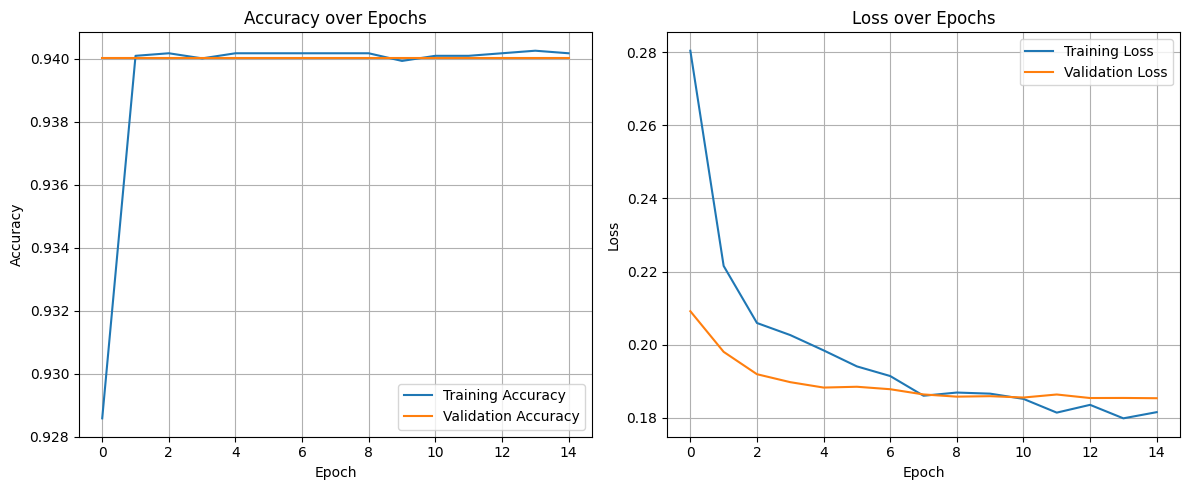

In [19]:

# Visualize training and validation accuracy by epoch
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
